# 雷达数据

## 雷达数据的绘制和上传redis




CPU times: user 12.4 s, sys: 180 ms, total: 12.6 s
Wall time: 2.34 s


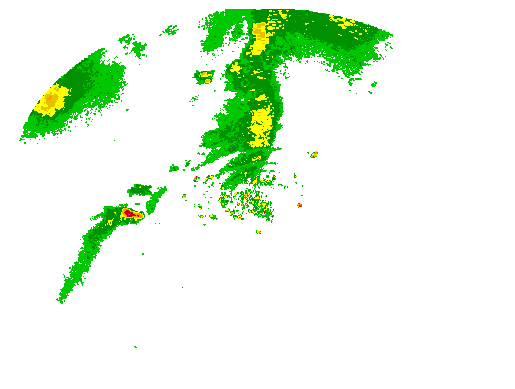

In [29]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)
    
class radar_data:
    def __init__(self):
        self.rs = redis.Redis(host='127.0.0.1', port=6379)
    def to_redis(self,imd):
        if self.rs.get("radar"):
            data = pickle.loads(self.rs.get("radar"))  
            radar_len = len(data['imglist'])
            if radar_len>10:
                data['imglist'] = data['imglist'][-9:]
                data['imglist'].append(imd)
            else:
                data['imglist'].append(imd)
        else:
            imglist = [imd]
            data = {
                "imglist":imglist
            }
        self.rs.set("radar", pickle.dumps(data))       
    def plot_data(self):
#         path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
#         f = cinrad.io.CinradReader(path+'Z_RADR_I_Z9576_20150809120400_O_DOR_SA_CAP.bin.bz2')
        path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
        f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
        tilt_number = 0
        data_radius = 230
        data_dtype = 'REF' # stands for reflectivity
        # 数据加载核心
        ra = f.get_data(tilt_number, data_radius, data_dtype)
        rl = list(f.iter_tilt(230, 'REF'))
        cr = cinrad.calc.quick_cr(rl)
        data = cr.CR
        output = data.interp(latitude=np.linspace(26.67, 30.57, 500),longitude = np.linspace(119.3, 123.7, 500),method="nearest")
        m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
        ## 颜色 ------
        colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
        levels1 = [15,20,25,30,35,40,45,50,55,60,65,70]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
        contour = plt.contourf(output.longitude, output.latitude, output,cmap=cmaps,levels = levels1)
        plt.axis('off') 
        geojson = geojsoncontour.contourf_to_geojson(
            contourf=contour,
            ndigits=3,
            unit='dbz'
        )
        self.to_redis(geojson)
    def get_radar(self):
        data = pickle.loads(self.rs.get("radar"))
        return data

worker = radar_data()
worker.plot_data()
#data = worker.get_radar()

In [3]:
a = [1,2,3,4,5,6,7,8,9,10,11,12]

In [6]:
a[-10:]

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# 雷达数据输出为geojosn


CPU times: user 24.9 s, sys: 139 ms, total: 25 s
Wall time: 4.54 s


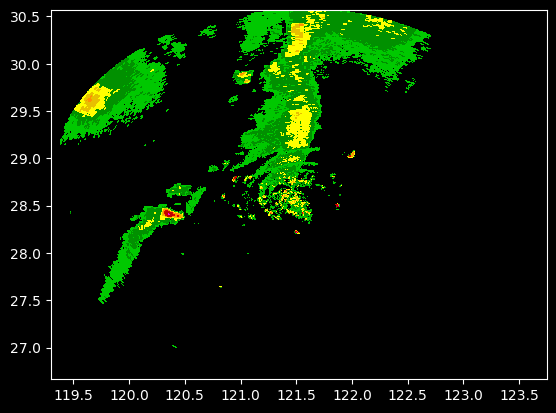

In [75]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
tilt_number = 0
data_radius = 230
data_dtype = 'REF' # stands for reflectivity
# 数据加载核心
ra = f.get_data(tilt_number, data_radius, data_dtype)
rl = list(f.iter_tilt(230, 'REF'))
cr = cinrad.easycalc.quick_cr(rl)
data = ra.data
m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
## 颜色 ------
colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
levels1 = [15,20,25,30,35,40,45,50,55,60,65,70]
cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
figure = plt.figure()
ax = figure.add_subplot(111)
contour = plt.contourf(cr.lon, cr.lat, cr.data,cmap=cmaps,levels = levels1)
geojson = geojsoncontour.contourf_to_geojson(
    geojson_filepath='out.geojson',
    contourf=contour,
    ndigits=5,
    unit='dbz'
)
# a = json.loas(geojson)

CPU times: user 13.5 s, sys: 50.4 ms, total: 13.5 s
Wall time: 2.55 s


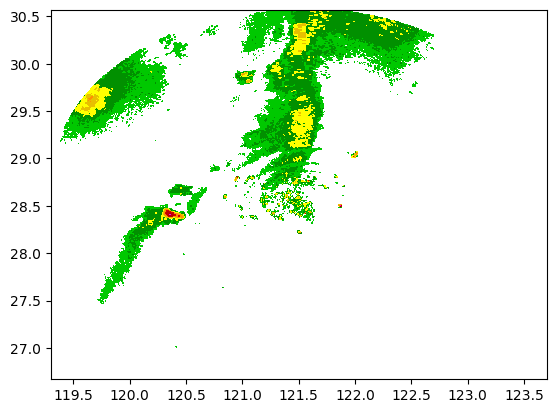

In [27]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
tilt_number = 0
data_radius = 230
data_dtype = 'REF' # stands for reflectivity
# 数据加载核心
ra = f.get_data(tilt_number, data_radius, data_dtype)
rl = list(f.iter_tilt(230, 'REF'))
cr = cinrad.calc.quick_cr(rl)
data = cr.CR
# output = data.interp(latitude=np.arange(26.67, 30.57, 0.0075),longitude = np.arange(119.3, 123.7, 0.0075),method="nearest")
output = data.interp(latitude=np.linspace(26.67, 30.57, 500),longitude = np.linspace(119.3, 123.7, 500),method="nearest")
m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
## 颜色 ------
colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
levels1 = [15,20,25,30,35,40,45,50,55,60,65,70]
cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
contour = plt.contourf(output.longitude, output.latitude, output,cmap=cmaps,levels = levels1)
geojson = geojsoncontour.contourf_to_geojson(
    geojson_filepath='out.geojson',
    contourf=contour,
    ndigits=3,
    unit='dbz'
)

In [28]:
output

<xarray.DataArray 'CR' (latitude: 500, longitude: 500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 26.67 26.68 26.69 26.69 ... 30.55 30.56 30.57
  * longitude  (longitude) float64 119.3 119.3 119.3 119.3 ... 123.7 123.7 123.7

In [3]:
tilt_number = 0
data_radius = 230
data_dtype = 'REF' # stands for reflectivity
# 数据加载核心
ra = f.get_data(tilt_number, data_radius, data_dtype)
rl = list(f.iter_tilt(230, 'REF'))
cr = cinrad.calc.quick_cr(rl)

/opt/conda/lib/python3.7/site-packages/cinrad/calc.py:110: RuntimeWarning: All-NaN axis encountered
  cr = np.nanmax(r_data, axis=0)


In [6]:
data = cr.CR

In [7]:
data

<xarray.DataArray 'CR' (latitude: 1000, longitude: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 26.67 26.67 26.67 26.68 ... 30.56 30.57 30.57
  * longitude  (longitude) float64 119.3 119.3 119.3 119.3 ... 123.7 123.7 123.7

In [9]:
a = data.interp(latitude=np.linspace(26.67, 30.57, 500),longitude = np.linspace(119.3, 123.7, 500),,method="linear")

In [14]:
a

<xarray.DataArray 'CR' (latitude: 500, longitude: 500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 26.67 26.68 26.69 26.69 ... 30.55 30.56 30.57
  * longitude  (longitude) float64 119.3 119.3 119.3 119.3 ... 123.7 123.7 123.7

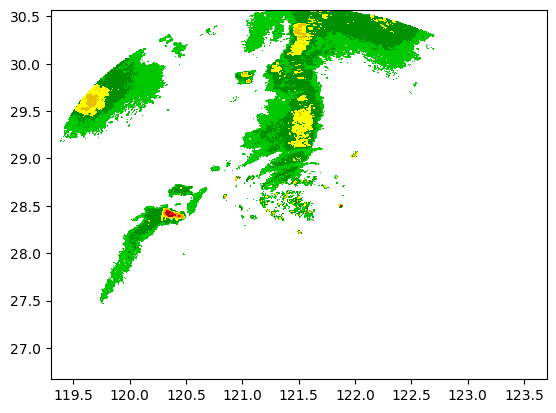

In [15]:
m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
## 颜色 ------
colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
levels1 = [15,20,25,30,35,40,45,50,55,60,65,70]
cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
figure = plt.figure()
ax = figure.add_subplot(111)
contour = plt.contourf(a.longitude, a.latitude, a,cmap=cmaps,levels = levels1)
geojson = geojsoncontour.contourf_to_geojson(
    geojson_filepath='out.geojson',
    contourf=contour,
    ndigits=5,
    unit='dbz'
)

2

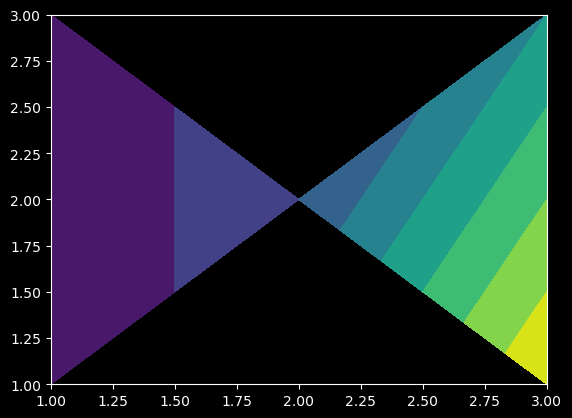

In [77]:

x = [[1,2,3],[1,2,3]]
y = [[3,2,1],[1,2,3]]
z = [[1,2,5],[1,2,3]]
contour = plt.contourf(x,y,z)
geojson = geojsoncontour.contourf_to_geojson(
#     geojson_filepath='out.geojson',
    contourf=contour,
    ndigits=1,
    unit='zbz'
)
len(x)

In [52]:
a = json.loads(geojson)